# Energy-aware Slice Placement – Data Analysis

This notebook analyzes the results obtained from the execution of the proposed
energy-aware MILP and heuristic algorithms for 5G slice placement.

The analysis focuses on:
- acceptance rate 
- total energy consumption,
- node activation and CPU utilization,
- routing characteristics,
- scalability and runtime behavior.

All results are generated from CSV files produced by the simulation pipeline.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["font.size"] = 11
sns.set_style("whitegrid")


In [3]:
RESULTS_DIR = "./results/2026-01-16_09-51-29/"  # ajuste aqui

df_metrics = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")
df_routes = pd.read_csv(f"{RESULTS_DIR}/routes_all_methods.csv")
df_node_cpu = pd.read_csv(f"{RESULTS_DIR}/node_cpu_load_all_methods.csv")
df_node_vnfs = pd.read_csv(f"{RESULTS_DIR}/node_vnfs_all_methods.csv")


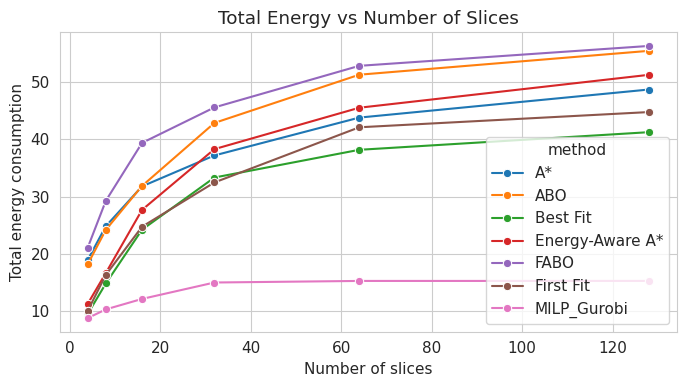

In [4]:
energy_avg = (
    df_metrics
    .groupby(["method", "num_slices"])["total_energy"]
    .mean()
    .reset_index()
)

sns.lineplot(
    data=energy_avg,
    x="num_slices",
    y="total_energy",
    hue="method",
    marker="o"
)

plt.xlabel("Number of slices")
plt.ylabel("Total energy consumption")
plt.title("Total Energy vs Number of Slices")
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load ---
RESULTS_DIR = "./results/2026-01-07_11-16-37"
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# --- Basic checks ---
required_cols = {"method", "num_slices", "num_vnfs_per_slice", "seed", "accepted"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in scalability_results.csv: {missing}")

# --- Acceptance rate (%) ---
df["acceptance_rate"] = 100.0 * df["accepted"] / df["num_slices"]

# Optional: stable method order (edit if you want)
method_order = ["MILP_Gurobi", "A*", "ABO", "FABO", "Best Fit", "First Fit", "Energy-Aware A*"]
present_methods = [m for m in method_order if m in df["method"].unique()]
if not present_methods:
    present_methods = sorted(df["method"].unique())

df.head()


,timestamp,num_slices,num_vnfs_per_slice,total_vnfs,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,acceptance_rate
0,2026-01-07 11:16:37,4,2,8,1,A*,4,7.80250,120.0,4.0,0.036866,100.0
1,2026-01-07 11:16:37,4,2,8,1,ABO,4,3.49500,120.0,8.0,3.572404,100.0
2,2026-01-07 11:16:37,4,2,8,1,FABO,4,9.64875,120.0,8.0,3.548676,100.0
3,2026-01-07 11:16:37,4,2,8,1,Best Fit,4,3.80250,120.0,4.0,0.015346,100.0
4,2026-01-07 11:16:37,4,2,8,1,First Fit,4,3.68250,120.0,12.0,0.002294,100.0


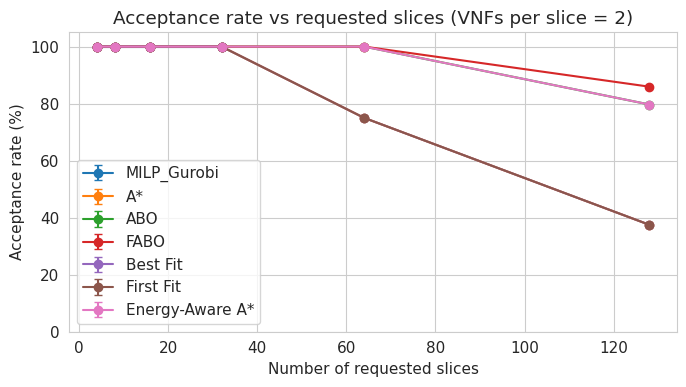

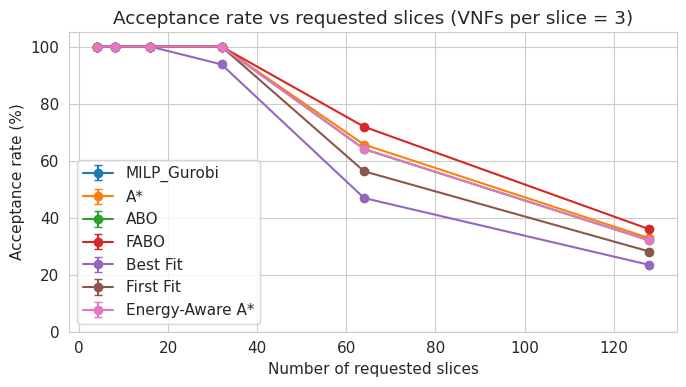

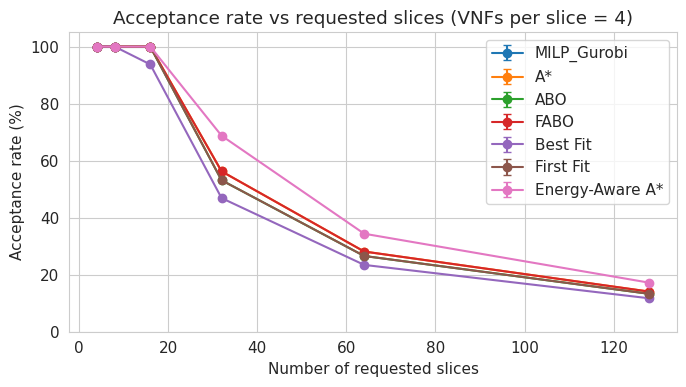

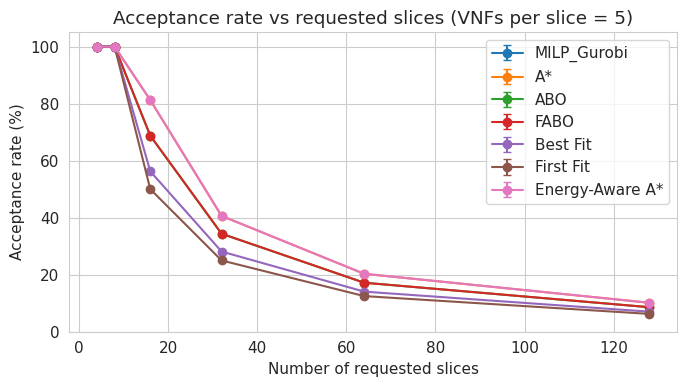

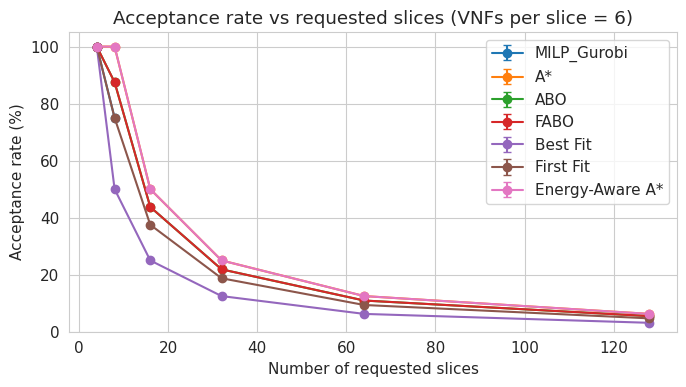

In [6]:
# Aggregate across seeds: mean + std
g = (
    df.groupby(["num_vnfs_per_slice", "num_slices", "method"])["acceptance_rate"]
      .agg(["mean", "std", "count"])
      .reset_index()
)

vnf_list = sorted(g["num_vnfs_per_slice"].unique())

for v in vnf_list:
    sub = g[g["num_vnfs_per_slice"] == v].copy()

    plt.figure()
    for method in present_methods:
        msub = sub[sub["method"] == method].sort_values("num_slices")
        if msub.empty:
            continue

        x = msub["num_slices"].to_numpy()
        y = msub["mean"].to_numpy()
        yerr = msub["std"].fillna(0).to_numpy()

        plt.errorbar(x, y, yerr=yerr, marker="o", linewidth=1.5, capsize=3, label=method)

    plt.xlabel("Number of requested slices")
    plt.ylabel("Acceptance rate (%)")
    plt.title(f"Acceptance rate vs requested slices (VNFs per slice = {v})")
    plt.ylim(0, 105)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RESULTS_DIR = "./results/2026-01-14_16-00-10/"
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")
EXCLUDED_METHODS = {"First Fit", "Best Fit"}
df = df[~df["method"].isin(EXCLUDED_METHODS)].copy()

required_cols = {
    "method", "num_slices", "num_vnfs_per_slice",
    "seed", "accepted", "total_energy"
}

missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Keep only cases with at least one accepted slice
df = df[df["accepted"] > 0].copy()

# Energy per accepted slice
df["energy_per_accepted_slice"] = df["total_energy"] / df["accepted"]

df.head()


,timestamp,num_slices,num_vnfs_per_slice,total_vnfs,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,energy_per_accepted_slice
0,2026-01-14 16:00:10,4,2,8,1,A*,4,7.80250,120.0,4.0,0.037009,1.950625
1,2026-01-14 16:00:10,4,2,8,1,ABO,4,3.49500,120.0,8.0,3.553110,0.873750
2,2026-01-14 16:00:10,4,2,8,1,FABO,4,9.64875,120.0,8.0,3.508740,2.412187
5,2026-01-14 16:00:10,4,2,8,1,Energy-Aware A*,4,7.61500,120.0,8.0,0.870434,1.903750
6,2026-01-14 16:00:10,4,2,8,1,MILP_Gurobi,4,3.80250,30.0,4.0,0.034436,0.950625


In [18]:
g = (
    df.groupby(["num_vnfs_per_slice", "num_slices", "method"])
      ["energy_per_accepted_slice"]
      .agg(["mean", "std", "count"])
      .reset_index()
)

# Optional: fixed method order
method_order = [
    "MILP_Gurobi",
    "A*",
    "Energy-Aware A*",
    "ABO",
    "FABO"
]

present_methods = [m for m in method_order if m in g["method"].unique()]
if not present_methods:
    present_methods = sorted(g["method"].unique())

g.head()


,num_vnfs_per_slice,num_slices,method,mean,std,count
0,2,4,A*,1.950625,0.0,5
1,2,4,ABO,0.873750,0.0,5
2,2,4,Energy-Aware A*,1.903750,0.0,5
3,2,4,FABO,2.412187,0.0,5
4,2,4,MILP_Gurobi,0.950625,0.0,5


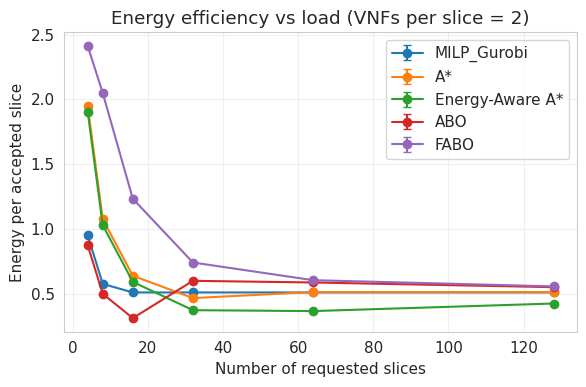

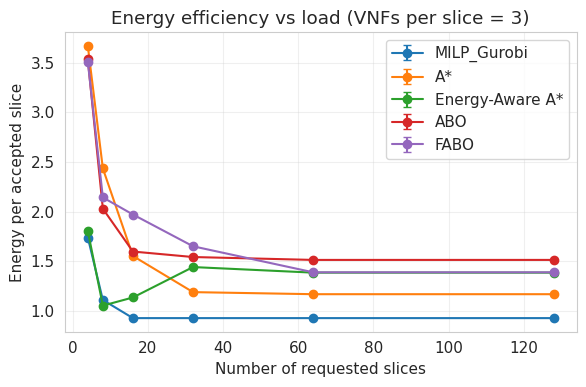

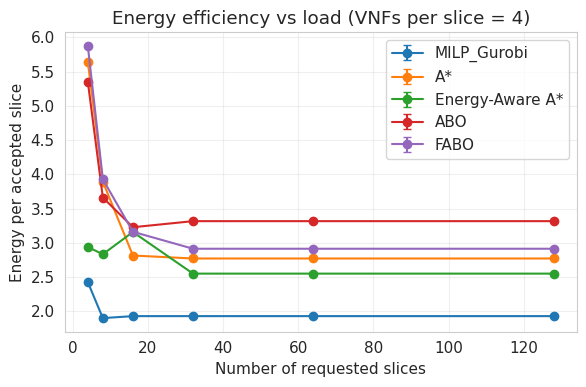

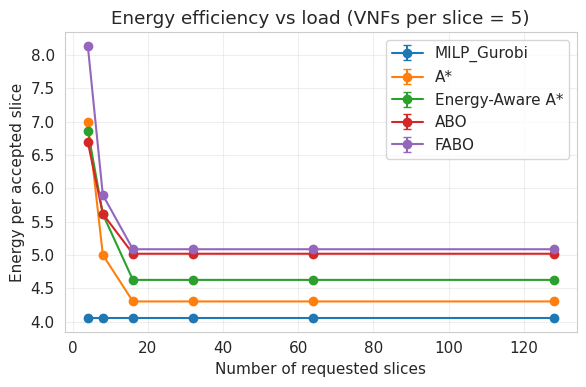

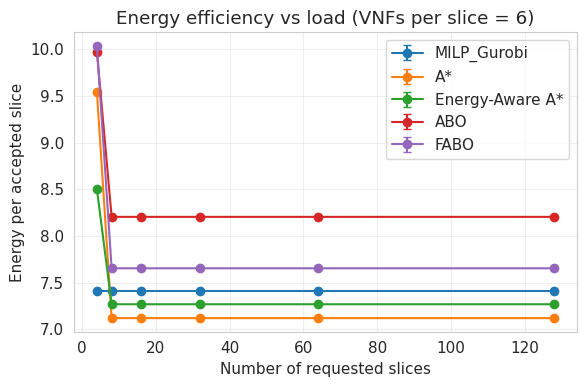

In [19]:
vnf_list = sorted(g["num_vnfs_per_slice"].unique())

for v in vnf_list:
    sub = g[g["num_vnfs_per_slice"] == v].copy()

    plt.figure(figsize=(6, 4))

    for method in present_methods:
        msub = sub[sub["method"] == method].sort_values("num_slices")
        if msub.empty:
            continue

        x = msub["num_slices"].to_numpy()
        y = msub["mean"].to_numpy()
        yerr = msub["std"].fillna(0).to_numpy()

        plt.errorbar(
            x, y,
            yerr=yerr,
            marker="o",
            linewidth=1.5,
            capsize=3,
            label=method,
        )

    plt.xlabel("Number of requested slices")
    plt.ylabel("Energy per accepted slice")
    plt.title(f"Energy efficiency vs load (VNFs per slice = {v})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [20]:
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Remove First Fit e Best Fit (como já decidido)
df = df[~df["method"].isin(["First Fit", "Best Fit"])].copy()

# 100% de aceitação → accepted == num_slices
df_100 = df[df["accepted"] == df["num_slices"]].copy()

print("Cenários com 100% de aceitação:", len(df_100))


Cenários com 100% de aceitação: 350


In [21]:
energy_agg = (
    df_100
    .groupby(["method", "num_slices"])
    .agg(
        mean_energy=("total_energy", "mean"),
        std_energy=("total_energy", "std"),
    )
    .reset_index()
)

energy_agg


,method,num_slices,mean_energy,std_energy
0,A*,4,22.239750,10.734535
1,A*,8,31.238625,17.012150
2,A*,16,26.705000,14.770103
3,A*,32,26.525000,12.243285
4,ABO,4,21.141250,12.455145
5,ABO,8,23.611875,15.609606
6,ABO,16,27.402708,19.757128
7,ABO,32,34.300937,15.948091
8,ABO,64,37.521875,0.000000
9,Energy-Aware A*,4,17.612250,11.255962


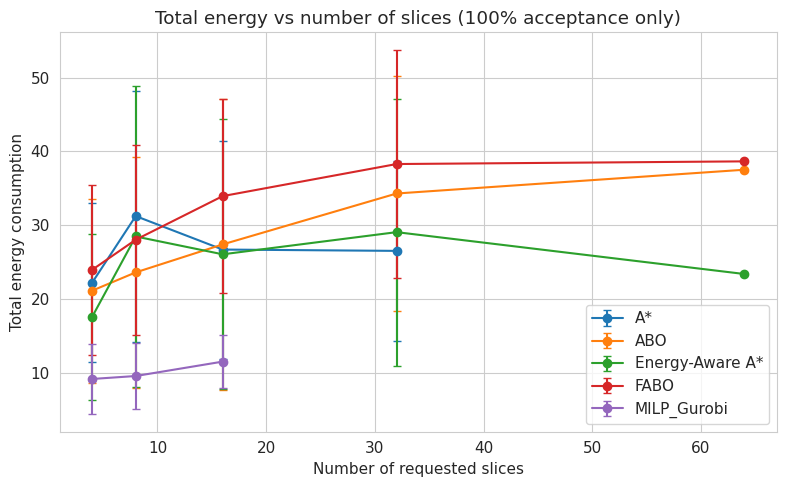

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for method in energy_agg["method"].unique():
    sub = energy_agg[energy_agg["method"] == method]

    plt.errorbar(
        sub["num_slices"],
        sub["mean_energy"],
        yerr=sub["std_energy"],
        marker="o",
        capsize=3,
        label=method,
    )

plt.xlabel("Number of requested slices")
plt.ylabel("Total energy consumption")
plt.title("Total energy vs number of slices (100% acceptance only)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Remove First Fit e Best Fit (como já decidido)
df = df[~df["method"].isin(["First Fit", "Best Fit"])].copy()

# 100% de aceitação → accepted == num_slices
df_100 = df[df["accepted"] == df["num_slices"]].copy()

print("Cenários com 100% de aceitação:", len(df_100))


Cenários com 100% de aceitação: 350


In [24]:
energy_agg = (
    df_100
    .groupby(["method", "num_vnfs_per_slice", "num_slices"])
    .agg(
        mean_energy=("total_energy", "mean"),
        std_energy=("total_energy", "std"),
    )
    .reset_index()
)

energy_agg.head()


,method,num_vnfs_per_slice,num_slices,mean_energy,std_energy
0,A*,2,4,7.8025,0.0
1,A*,2,8,8.6050,0.0
2,A*,2,16,10.2100,0.0
3,A*,2,32,14.9100,0.0
4,A*,3,4,14.6675,0.0


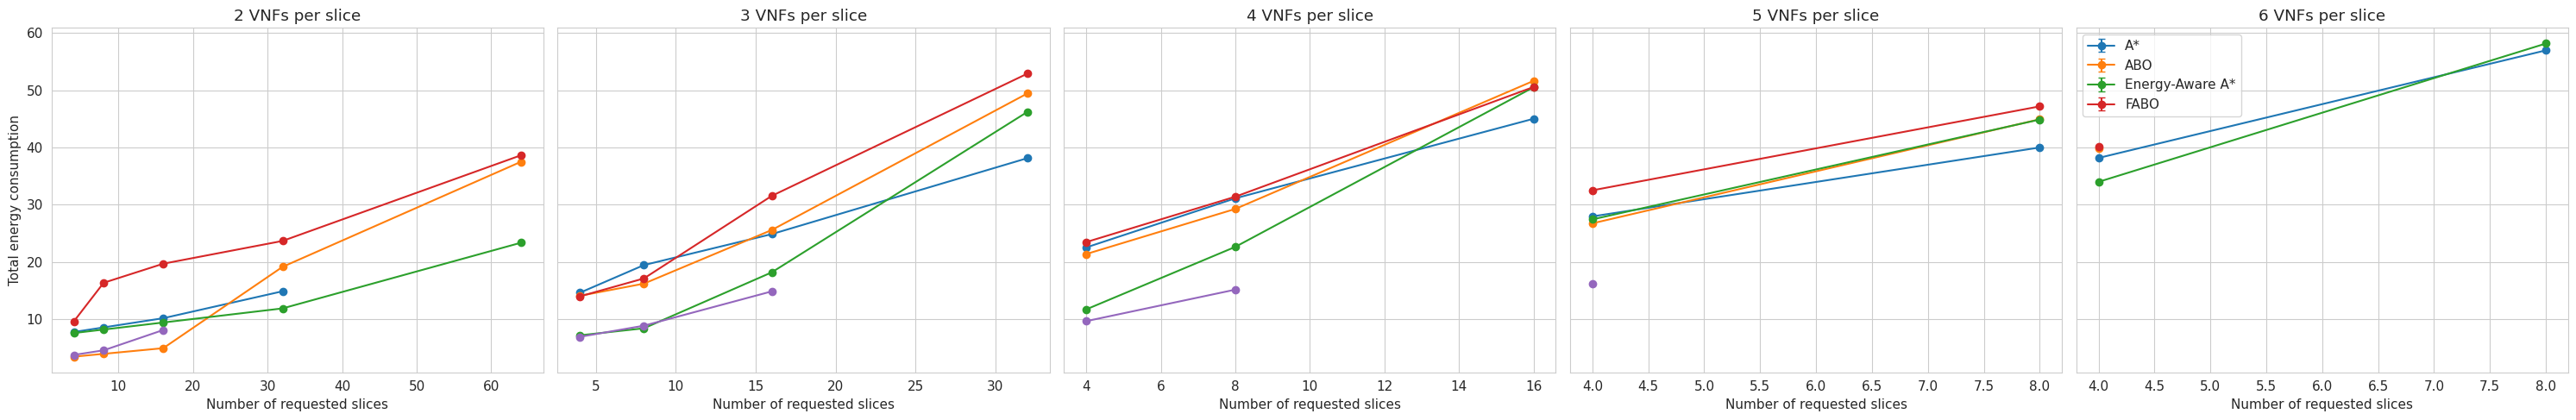

In [25]:
import matplotlib.pyplot as plt

vnf_values = sorted(energy_agg["num_vnfs_per_slice"].unique())

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(vnf_values),
    figsize=(6 * len(vnf_values), 5),
    sharey=True,
)

if len(vnf_values) == 1:
    axes = [axes]

for ax, vnf in zip(axes, vnf_values):
    sub_vnf = energy_agg[energy_agg["num_vnfs_per_slice"] == vnf]

    for method in sub_vnf["method"].unique():
        sub = sub_vnf[sub_vnf["method"] == method]

        ax.errorbar(
            sub["num_slices"],
            sub["mean_energy"],
            yerr=sub["std_energy"],
            marker="o",
            capsize=3,
            label=method,
        )

    ax.set_title(f"{vnf} VNFs per slice")
    ax.set_xlabel("Number of requested slices")
    ax.grid(True)

axes[0].set_ylabel("Total energy consumption")
axes[-1].legend()
plt.tight_layout()
plt.show()


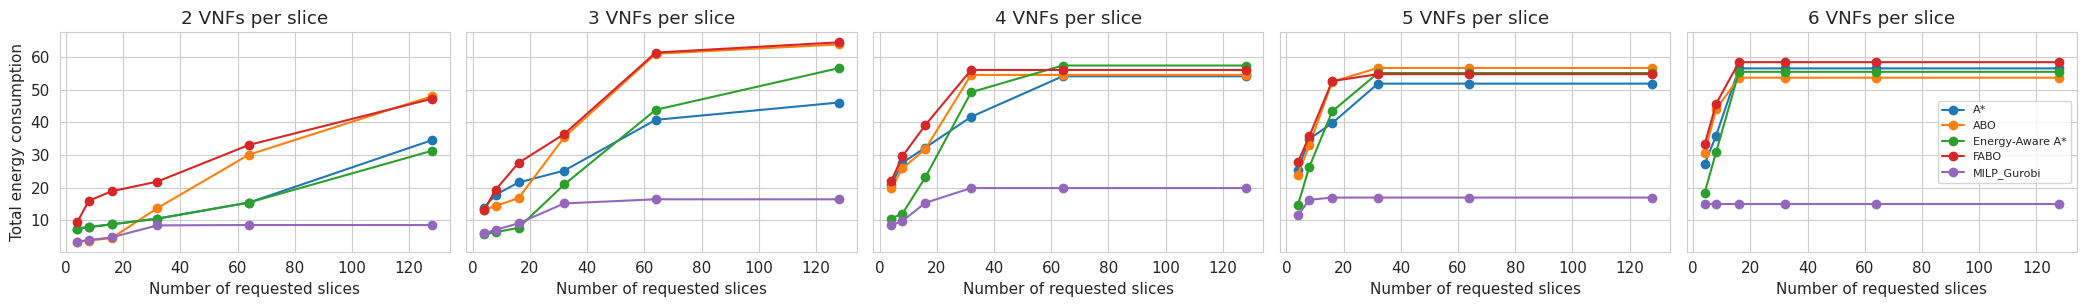

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Optional: remove methods you don't want
methods_to_exclude = ["First Fit", "Best Fit"]
df = df[~df["method"].isin(methods_to_exclude)].copy()

# Ensure numeric types
df["num_slices"] = pd.to_numeric(df["num_slices"], errors="coerce")
df["num_vnfs_per_slice"] = pd.to_numeric(df["num_vnfs_per_slice"], errors="coerce")
df["total_energy"] = pd.to_numeric(df["total_energy"], errors="coerce")

# Drop invalid rows
df = df.dropna(subset=["num_slices", "num_vnfs_per_slice", "total_energy", "method"])

# Aggregate across seeds (mean). Change to 'median' if you prefer robustness.
agg = (
    df.groupby(["num_vnfs_per_slice", "method", "num_slices"], as_index=False)
      .agg(total_energy=("total_energy", "mean"))
)

# Sort for clean lines
agg = agg.sort_values(["num_vnfs_per_slice", "method", "num_slices"])

# Subplots layout (1 row like your example)
vnf_values = sorted(agg["num_vnfs_per_slice"].unique())
k = len(vnf_values)

fig, axes = plt.subplots(1, k, figsize=(4.2 * k, 3.2), sharey=True)

# If only one subplot, make axes iterable
if k == 1:
    axes = [axes]

for ax, v in zip(axes, vnf_values):
    sub = agg[agg["num_vnfs_per_slice"] == v]

    for method, g in sub.groupby("method"):
        g = g.sort_values("num_slices")
        ax.plot(
            g["num_slices"],
            g["total_energy"],
            marker="o",
            label=method,
        )

    ax.set_title(f"{int(v)} VNFs per slice")
    ax.set_xlabel("Number of requested slices")
    ax.grid(True)

axes[0].set_ylabel("Total energy consumption")

# Put legend only once (last subplot), like many papers do
axes[-1].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()



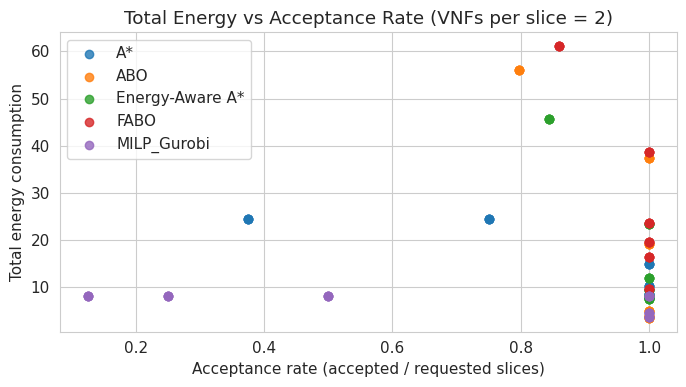

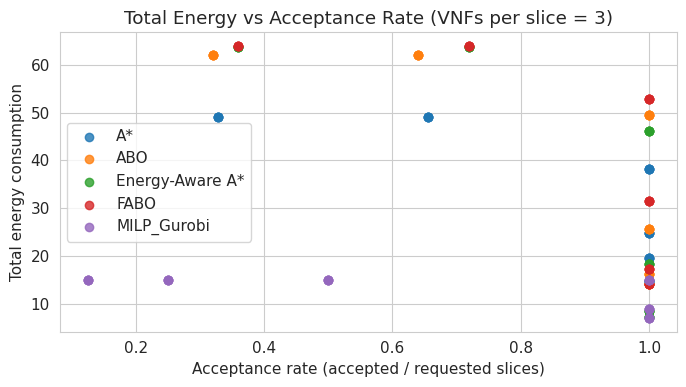

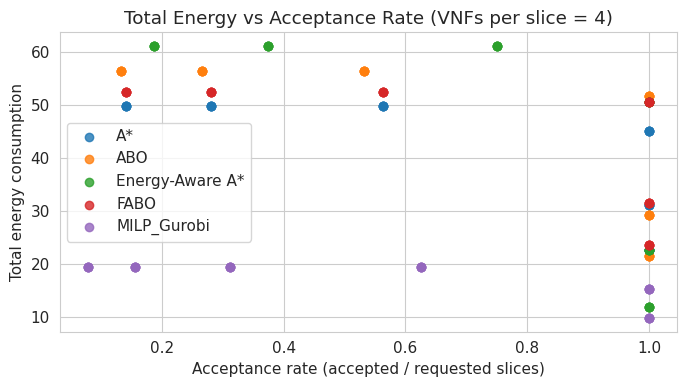

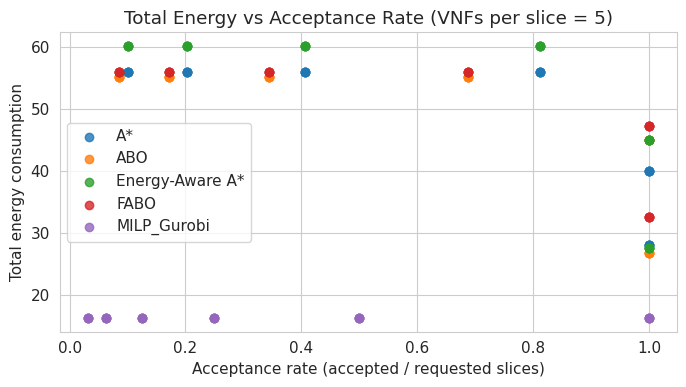

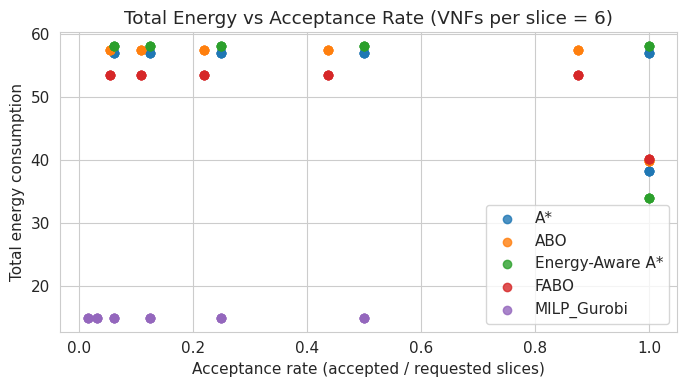

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Remove methods you don't want in the analysis
methods_to_exclude = ["First Fit", "Best Fit"]
df = df[~df["method"].isin(methods_to_exclude)]

# Recompute acceptance rate explicitly
df = df.copy()
df["acceptance_rate"] = df["accepted"] / df["num_slices"]

# Drop invalid rows
df = df.dropna(subset=["acceptance_rate", "total_energy", "num_vnfs_per_slice"])

# Plot: one figure per VNF-per-slice configuration
for num_vnfs, df_vnf in df.groupby("num_vnfs_per_slice"):
    plt.figure()
    for method, g in df_vnf.groupby("method"):
        plt.scatter(
            g["acceptance_rate"],
            g["total_energy"],
            label=method,
            alpha=0.8,
        )

    plt.xlabel("Acceptance rate (accepted / requested slices)")
    plt.ylabel("Total energy consumption")
    plt.title(f"Total Energy vs Acceptance Rate (VNFs per slice = {num_vnfs})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


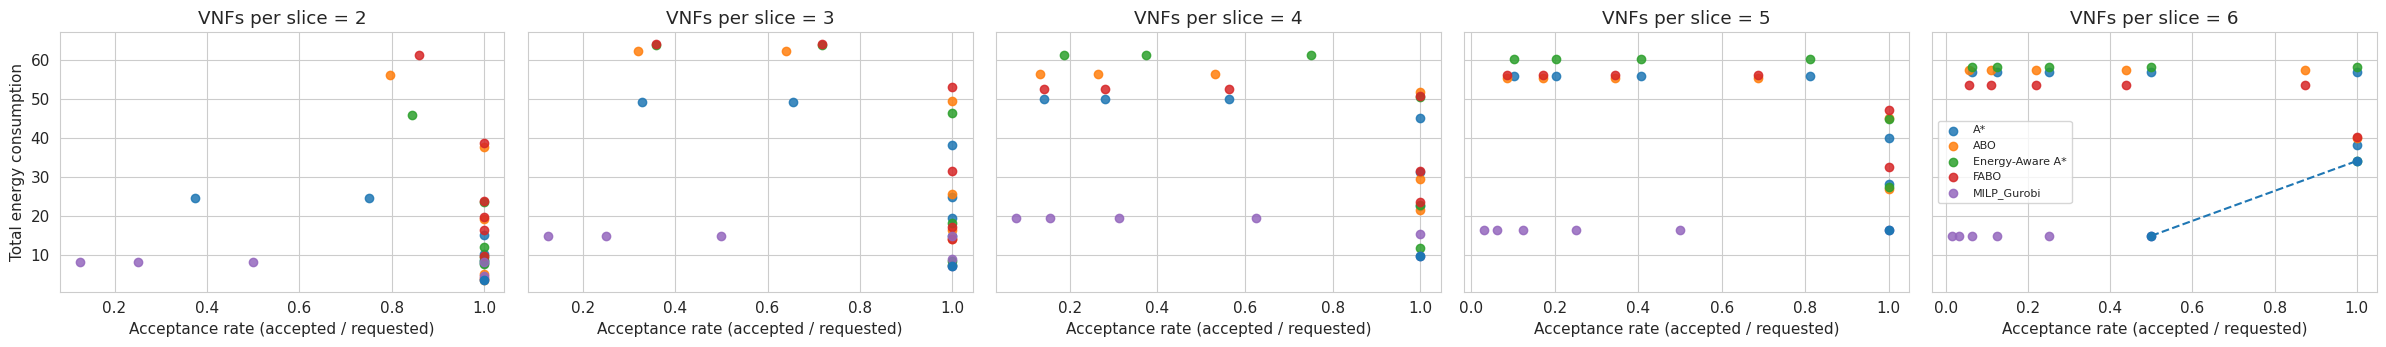

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def pareto_frontier(df_xy, x_col, y_col):
    # English: Returns a boolean mask of non-dominated points (maximize x, minimize y).
    x = df_xy[x_col].to_numpy()
    y = df_xy[y_col].to_numpy()
    n = len(df_xy)
    keep = np.ones(n, dtype=bool)

    for i in range(n):
        if not keep[i]:
            continue
        # English: j dominates i if x_j >= x_i and y_j <= y_i, with at least one strict.
        dominates = (x >= x[i]) & (y <= y[i]) & ((x > x[i]) | (y < y[i]))
        if np.any(dominates):
            keep[i] = False
    return keep

# Load results
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Optional: remove methods you don't want
methods_to_exclude = ["First Fit", "Best Fit"]
df = df[~df["method"].isin(methods_to_exclude)].copy()

# Ensure numeric types
df["num_slices"] = pd.to_numeric(df["num_slices"], errors="coerce")
df["num_vnfs_per_slice"] = pd.to_numeric(df["num_vnfs_per_slice"], errors="coerce")
df["accepted"] = pd.to_numeric(df["accepted"], errors="coerce")
df["total_energy"] = pd.to_numeric(df["total_energy"], errors="coerce")

# Acceptance rate = accepted / requested
df["acceptance_rate"] = df["accepted"] / df["num_slices"]

# Drop invalid rows
df = df.dropna(subset=["acceptance_rate", "total_energy", "num_vnfs_per_slice", "method"])

# Aggregate across seeds (mean) per (vnfs, method, num_slices)
agg = (
    df.groupby(["num_vnfs_per_slice", "method", "num_slices"], as_index=False)
      .agg(
          acceptance_rate=("acceptance_rate", "mean"),
          total_energy=("total_energy", "mean"),
      )
)

vnf_values = sorted(agg["num_vnfs_per_slice"].unique())
k = len(vnf_values)

fig, axes = plt.subplots(1, k, figsize=(4.8 * k, 3.6), sharey=True)

if k == 1:
    axes = [axes]

for ax, v in zip(axes, vnf_values):
    sub = agg[agg["num_vnfs_per_slice"] == v].copy()

    # Scatter per method
    for method, g in sub.groupby("method"):
        ax.scatter(g["acceptance_rate"], g["total_energy"], label=method, alpha=0.85)

    # Global Pareto frontier (across all methods)
    mask = pareto_frontier(sub[["acceptance_rate", "total_energy"]],
                           x_col="acceptance_rate", y_col="total_energy")
    pf = sub.loc[mask].sort_values(["acceptance_rate", "total_energy"])

    # Draw frontier line
    ax.plot(pf["acceptance_rate"], pf["total_energy"], linestyle="--", marker="o")

    ax.set_title(f"VNFs per slice = {int(v)}")
    ax.set_xlabel("Acceptance rate (accepted / requested)")
    ax.grid(True)

axes[0].set_ylabel("Total energy consumption")
axes[-1].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


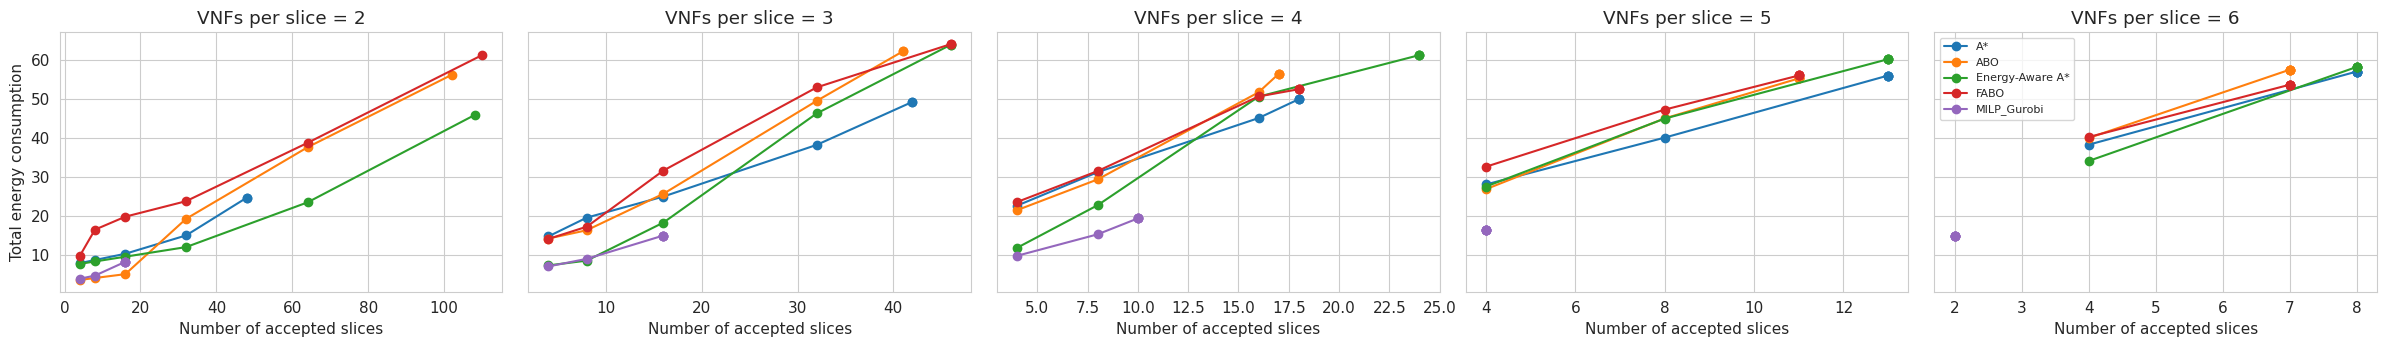

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results

df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Optional: remove methods you don't want
methods_to_exclude = ["First Fit", "Best Fit"]
df = df[~df["method"].isin(methods_to_exclude)].copy()

# Ensure numeric types
df["num_slices"] = pd.to_numeric(df["num_slices"], errors="coerce")
df["num_vnfs_per_slice"] = pd.to_numeric(df["num_vnfs_per_slice"], errors="coerce")
df["accepted"] = pd.to_numeric(df["accepted"], errors="coerce")
df["total_energy"] = pd.to_numeric(df["total_energy"], errors="coerce")

df = df.dropna(subset=["num_vnfs_per_slice", "method", "accepted", "total_energy"])

# Aggregate across seeds (mean) per (vnfs, method, num_slices)
agg = (
    df.groupby(["num_vnfs_per_slice", "method", "num_slices"], as_index=False)
      .agg(
          accepted=("accepted", "mean"),
          total_energy=("total_energy", "mean"),
      )
)

# Sort and build subplots like your example
vnf_values = sorted(agg["num_vnfs_per_slice"].unique())
k = len(vnf_values)

fig, axes = plt.subplots(1, k, figsize=(4.8 * k, 3.6), sharey=True)

if k == 1:
    axes = [axes]

for ax, v in zip(axes, vnf_values):
    sub = agg[agg["num_vnfs_per_slice"] == v].copy()

    for method, g in sub.groupby("method"):
        g = g.sort_values("accepted")
        ax.plot(
            g["accepted"],
            g["total_energy"],
            marker="o",
            label=method,
        )

    ax.set_title(f"VNFs per slice = {int(v)}")
    ax.set_xlabel("Number of accepted slices")
    ax.grid(True)

axes[0].set_ylabel("Total energy consumption")
axes[-1].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


In [15]:
RESULTS_DIR = "./results/2026-01-14_09-47-51"

df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Remove First Fit e Best Fit (como já decidido)
df = df[~df["method"].isin(["First Fit", "Best Fit"])].copy()

# 100% de aceitação → accepted == num_slices
df_100 = df[df["accepted"] == df["num_slices"]].copy()

print("Cenários com 100% de aceitação:", len(df_100))


Cenários com 100% de aceitação: 24


In [16]:
energy_agg = (
    df_100
    .groupby(["method", "num_vnfs_per_slice", "num_slices"])
    .agg(
        mean_energy=("total_energy", "mean"),
        std_energy=("total_energy", "std"),
    )
    .reset_index()
)

energy_agg


,method,num_vnfs_per_slice,num_slices,mean_energy,std_energy
0,A*,3,4,14.667500,NaN
1,A*,3,8,19.482500,NaN
2,A*,3,16,24.885000,NaN
3,A*,4,4,22.563750,NaN
4,A*,4,8,31.135000,NaN
5,A*,4,16,45.020000,NaN
6,ABO,3,4,14.122500,NaN
7,ABO,3,8,16.245000,NaN
8,ABO,3,16,25.598750,NaN
9,ABO,4,4,21.410000,NaN


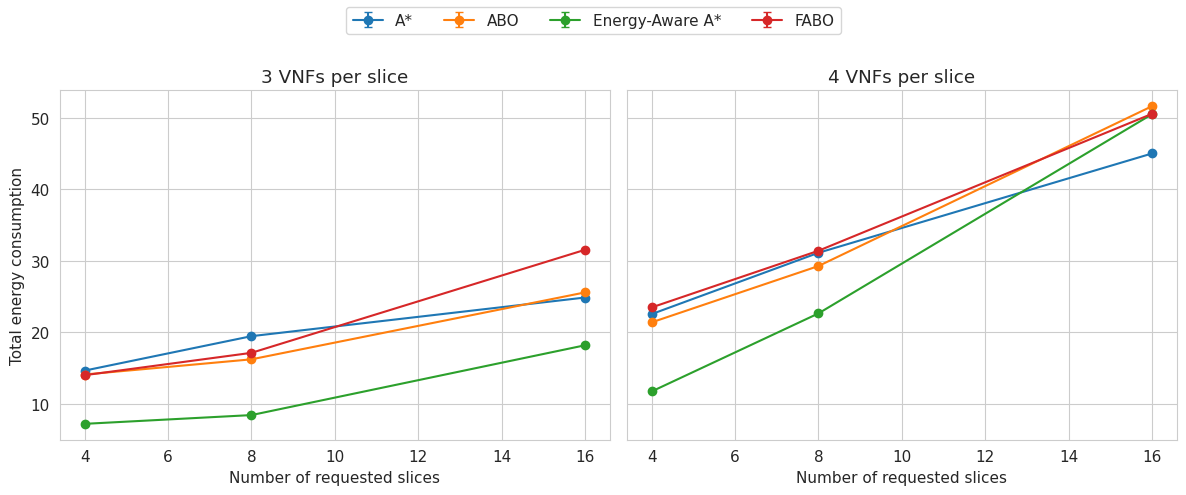

In [17]:
import matplotlib.pyplot as plt

vnf_values = sorted(energy_agg["num_vnfs_per_slice"].unique())

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(vnf_values),
    figsize=(6 * len(vnf_values), 5),
    sharey=True,
)

# Ensure axes is iterable
if len(vnf_values) == 1:
    axes = [axes]

for ax, vnf in zip(axes, vnf_values):
    sub_vnf = energy_agg[energy_agg["num_vnfs_per_slice"] == vnf]

    for method in sub_vnf["method"].unique():
        sub = sub_vnf[sub_vnf["method"] == method]

        ax.errorbar(
            sub["num_slices"],
            sub["mean_energy"],
            yerr=sub["std_energy"],
            marker="o",
            capsize=3,
            label=method,  # Label must be set for legend
        )

    ax.set_title(f"{vnf} VNFs per slice")
    ax.set_xlabel("Number of requested slices")
    ax.grid(True)

axes[0].set_ylabel("Total energy consumption")

# --- GLOBAL legend (fixes missing MILP) ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=len(labels),
)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space for legend
plt.show()


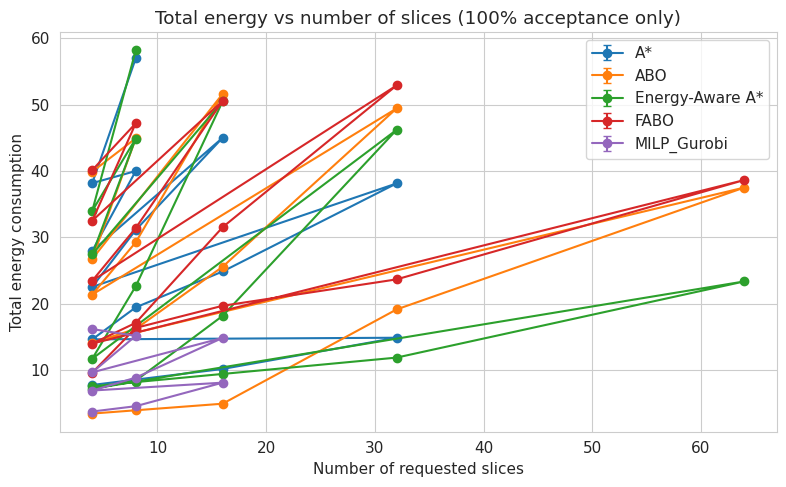

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for method in energy_agg["method"].unique():
    sub = energy_agg[energy_agg["method"] == method]

    plt.errorbar(
        sub["num_slices"],
        sub["mean_energy"],
        yerr=sub["std_energy"],
        marker="o",
        capsize=3,
        label=method,
    )

plt.xlabel("Number of requested slices")
plt.ylabel("Total energy consumption")
plt.title("Total energy vs number of slices (100% acceptance only)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
for v in vnf_list:
    sub = g[g["num_vnfs_per_slice"] == v].copy()

    plt.figure(figsize=(6, 4))

    for method in present_methods:
        msub = sub[sub["method"] == method].sort_values("num_slices")
        if msub.empty:
            continue

        plt.plot(
            msub["num_slices"],
            msub["mean"],
            marker="o",
            linewidth=1.5,
            label=method,
        )

    plt.yscale("log")
    plt.xlabel("Number of requested slices")
    plt.ylabel("Energy per accepted slice (log scale)")
    plt.title(f"Energy efficiency vs load (VNFs per slice = {v})")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()


NameError: name 'vnf_list' is not defined

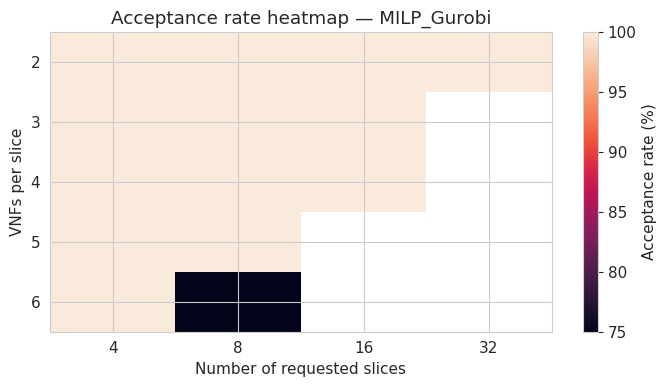

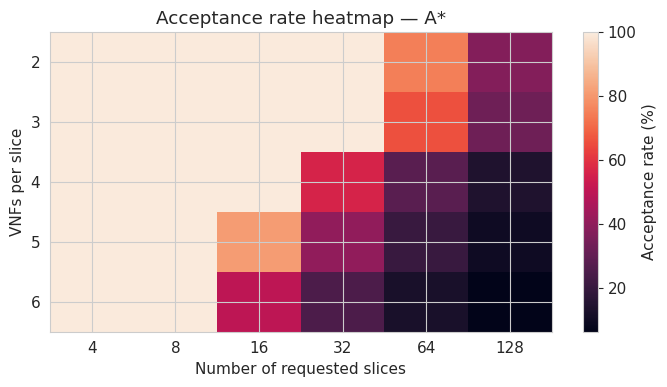

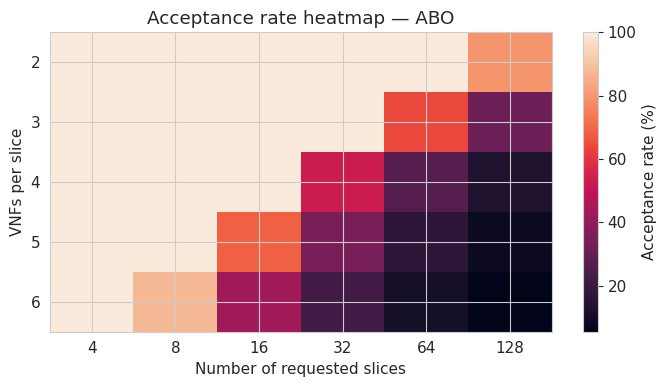

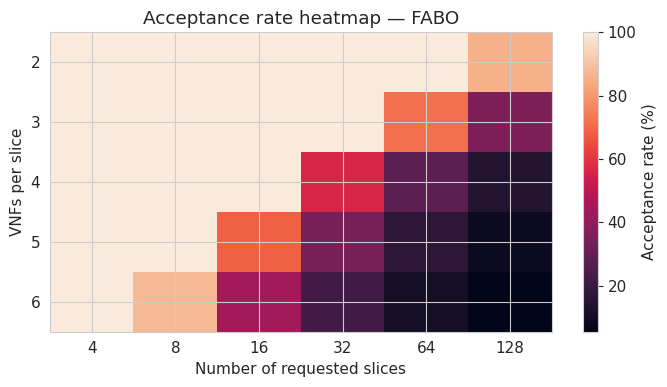

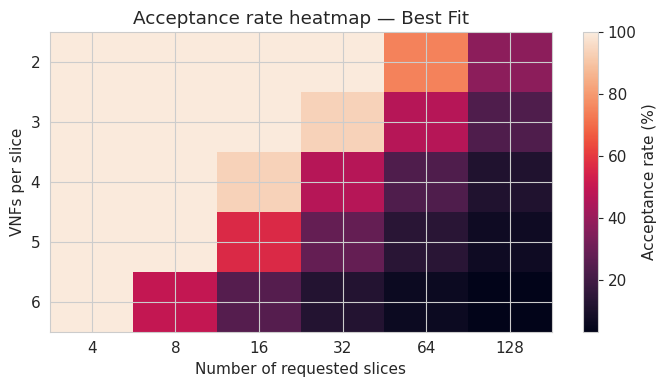

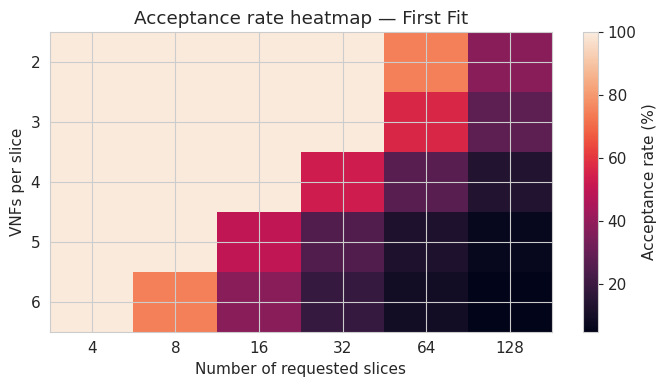

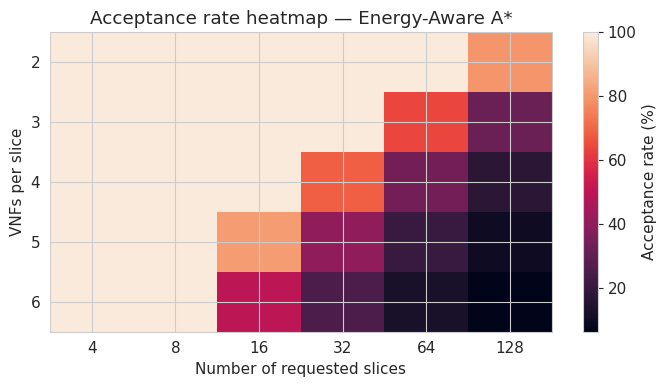

In [19]:
for method in present_methods:
    sub = df[df["method"] == method].copy()
    if sub.empty:
        continue

    pivot = (
        sub.groupby(["num_vnfs_per_slice", "num_slices"])["acceptance_rate"]
           .mean()
           .reset_index()
           .pivot(index="num_vnfs_per_slice", columns="num_slices", values="acceptance_rate")
           .sort_index()
    )

    plt.figure()
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(label="Acceptance rate (%)")
    plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns)
    plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
    plt.xlabel("Number of requested slices")
    plt.ylabel("VNFs per slice")
    plt.title(f"Acceptance rate heatmap — {method}")
    plt.tight_layout()
    plt.show()


In [11]:
g2 = (
    df.groupby(["num_vnfs_per_slice", "num_slices", "method"])["accepted"]
      .agg(["mean", "std", "count"])
      .reset_index()
)

vnf_list = sorted(g2["num_vnfs_per_slice"].unique())

for v in vnf_list:
    sub = g2[g2["num_vnfs_per_slice"] == v].copy()

    plt.figure()
    for method in present_methods:
        msub = sub[sub["method"] == method].sort_values("num_slices")
        if msub.empty:
            continue

        x = msub["num_slices"].to_numpy()
        y = msub["mean"].to_numpy()
        yerr = msub["std"].fillna(0).to_numpy()

        plt.errorbar(x, y, yerr=yerr, marker="o", linewidth=1.5, capsize=3, label=method)

    plt.xlabel("Number of requested slices")
    plt.ylabel("Accepted slices (mean)")
    plt.title(f"Accepted slices vs requested slices (VNFs per slice = {v})")
    plt.ylim(0, max(sub["num_slices"]) + 1)
    plt.legend()
    plt.tight_layout()
    plt.show()


NameError: name 'present_methods' is not defined

<Figure size 700x400 with 0 Axes>

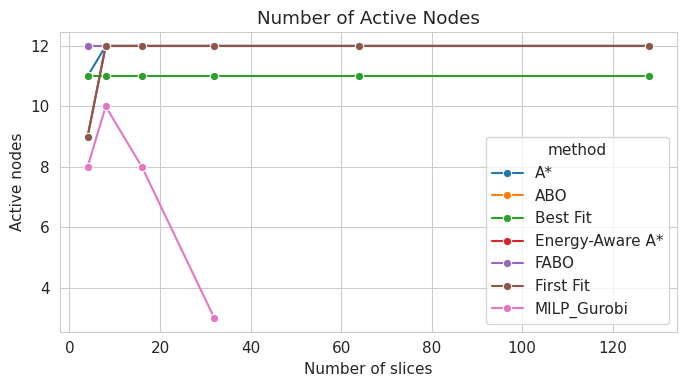

In [11]:
active_nodes = (
    df_node_cpu[df_node_cpu["cpu_used"] > 0]
    .groupby(["method", "num_slices"])["node"]
    .nunique()
    .reset_index(name="active_nodes")
)

sns.lineplot(
    data=active_nodes,
    x="num_slices",
    y="active_nodes",
    hue="method",
    marker="o"
)

plt.xlabel("Number of slices")
plt.ylabel("Active nodes")
plt.title("Number of Active Nodes")
plt.tight_layout()
plt.show()


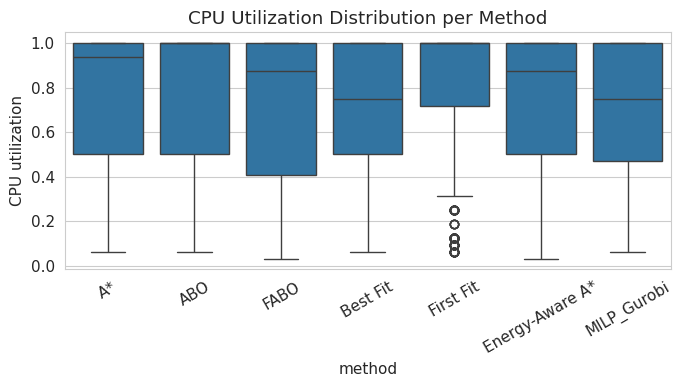

In [12]:
df_cpu_nonzero = df_node_cpu[df_node_cpu["cpu_used"] > 0]

sns.boxplot(
    data=df_cpu_nonzero,
    x="method",
    y="cpu_utilization"
)

plt.ylabel("CPU utilization")
plt.title("CPU Utilization Distribution per Method")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


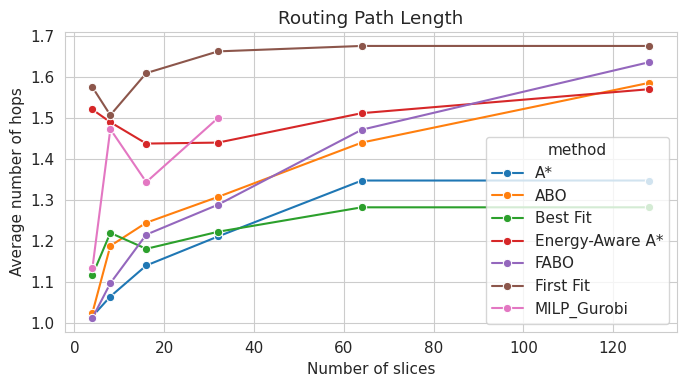

In [14]:
route_len = (
    df_routes
    .groupby(["method", "num_slices"])["num_hops"]
    .mean()
    .reset_index()
)

sns.lineplot(
    data=route_len,
    x="num_slices",
    y="num_hops",
    hue="method",
    marker="o"
)

plt.xlabel("Number of slices")
plt.ylabel("Average number of hops")
plt.title("Routing Path Length")
plt.tight_layout()
plt.show()


In [12]:
sns.lineplot(
    data=df_metrics,
    x="num_slices",
    y="runtime_sec",
    hue="method",
    marker="o"
)

plt.yscale("log")
plt.xlabel("Number of slices")
plt.ylabel("Runtime (seconds, log scale)")
plt.title("Runtime Scalability")
plt.tight_layout()
plt.show()


NameError: name 'df_metrics' is not defined